In [20]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


In [21]:
# 1. Load dataset

# Step 1: Load Dataset
df = pd.read_excel(r"D:\data science\Assignments\assignment pnyb\EastWestAirlines.xlsx", sheet_name="data")

# Display first few rows
df.head()

# Basic info
df.info()
df.describe()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   ID#                3999 non-null   int64
 1   Balance            3999 non-null   int64
 2   Qual_miles         3999 non-null   int64
 3   cc1_miles          3999 non-null   int64
 4   cc2_miles          3999 non-null   int64
 5   cc3_miles          3999 non-null   int64
 6   Bonus_miles        3999 non-null   int64
 7   Bonus_trans        3999 non-null   int64
 8   Flight_miles_12mo  3999 non-null   int64
 9   Flight_trans_12    3999 non-null   int64
 10  Days_since_enroll  3999 non-null   int64
 11  Award?             3999 non-null   int64
dtypes: int64(12)
memory usage: 375.0 KB


,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
count,3999.000000,3.999000e+03,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.00000,3999.000000,3999.000000,3999.00000,3999.000000
mean,2014.819455,7.360133e+04,144.114529,2.059515,1.014504,1.012253,17144.846212,11.60190,460.055764,1.373593,4118.55939,0.370343
std,1160.764358,1.007757e+05,773.663804,1.376919,0.147650,0.195241,24150.967826,9.60381,1400.209171,3.793172,2065.13454,0.482957
min,1.000000,0.000000e+00,0.000000,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,2.00000,0.000000
25%,1010.500000,1.852750e+04,0.000000,1.000000,1.000000,1.000000,1250.000000,3.00000,0.000000,0.000000,2330.00000,0.000000
50%,2016.000000,4.309700e+04,0.000000,1.000000,1.000000,1.000000,7171.000000,12.00000,0.000000,0.000000,4096.00000,0.000000
75%,3020.500000,9.240400e+04,0.000000,3.000000,1.000000,1.000000,23800.500000,17.00000,311.000000,1.000000,5790.50000,1.000000
max,4021.000000,1.704838e+06,11148.000000,5.000000,3.000000,5.000000,263685.000000,86.00000,30817.000000,53.000000,8296.00000,1.000000


In [22]:
# 2. Basic checks & missing handling
# Step 2: Handle Missing Values
# Using mean imputation for numerical columns
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [5]:
# 3. Encode categorical -> numeric

label_encoders = {}
for col in df.columns:
    if df[col].dtype == 'object' or df[col].dtype.name == 'category':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

print("\nDtypes after encoding:\n", df.dtypes)


Dtypes after encoding:
 ID#                  int64
Balance              int64
Qual_miles           int64
cc1_miles            int64
cc2_miles            int64
cc3_miles            int64
Bonus_miles          int64
Bonus_trans          int64
Flight_miles_12mo    int64
Flight_trans_12      int64
Days_since_enroll    int64
Award?               int64
dtype: object


In [23]:
# Step 3: Outlier Removal using IQR
Q1 = df_imputed.quantile(0.25)
Q3 = df_imputed.quantile(0.75)
IQR = Q3 - Q1

df_clean = df_imputed[~((df_imputed < (Q1 - 1.5 * IQR)) | (df_imputed > (Q3 + 1.5 * IQR))).any(axis=1)]

print(f"Original dataset shape: {df.shape}")
print(f"Cleaned dataset shape: {df_clean.shape}")


Original dataset shape: (3999, 12)
Cleaned dataset shape: (2875, 12)


In [24]:
# Step 4: Feature Scaling
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clean)


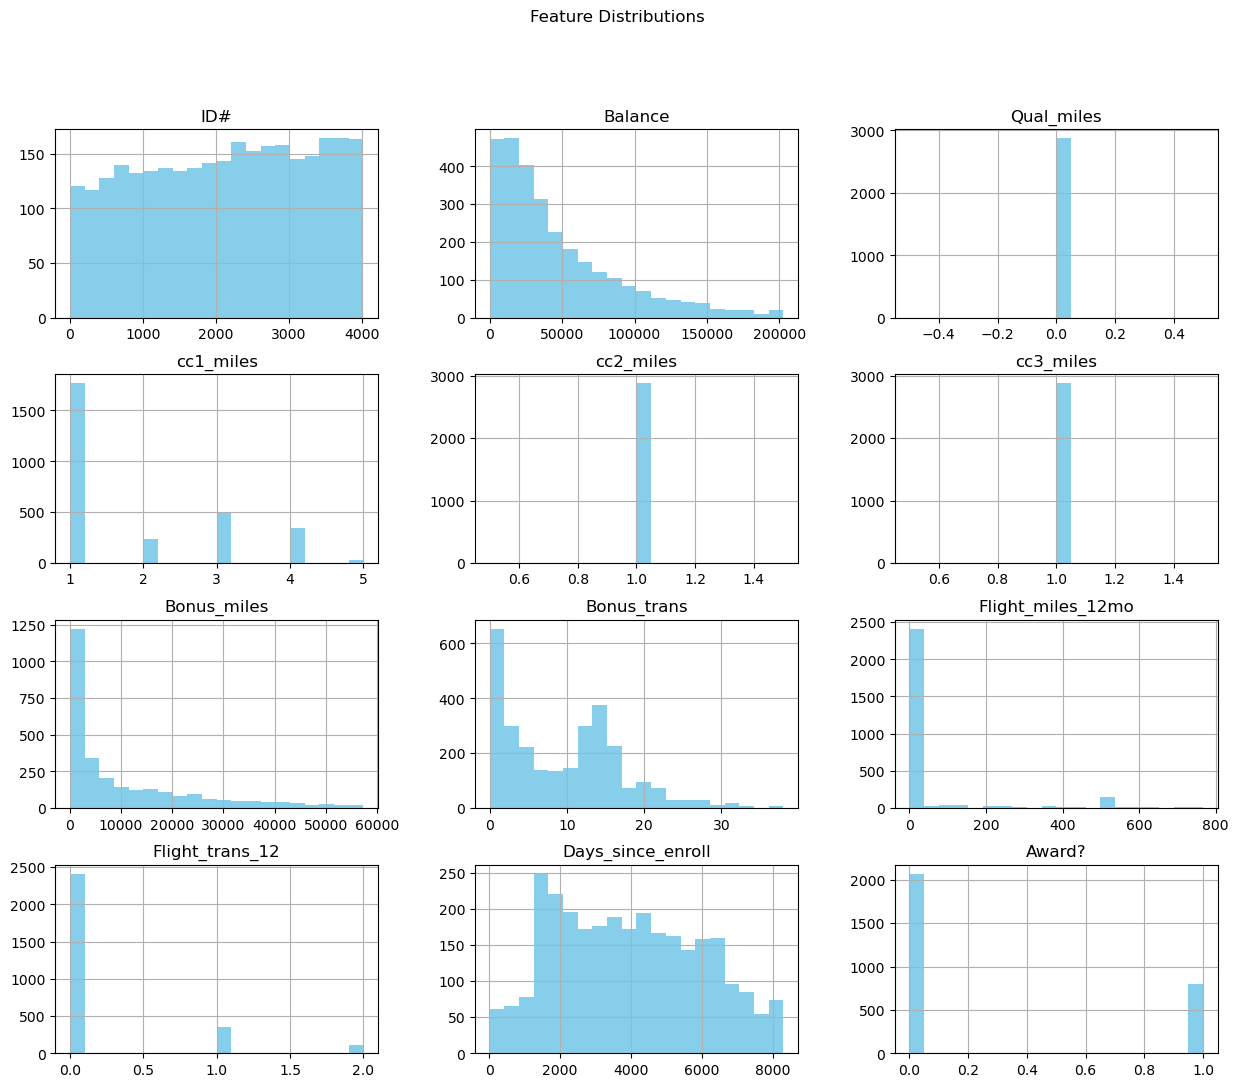

In [25]:
# Step 5: Exploratory Data Analysis (EDA)
# Histograms
df_clean.hist(figsize=(15,12), bins=20, color='skyblue')
plt.suptitle("Feature Distributions")
plt.show()


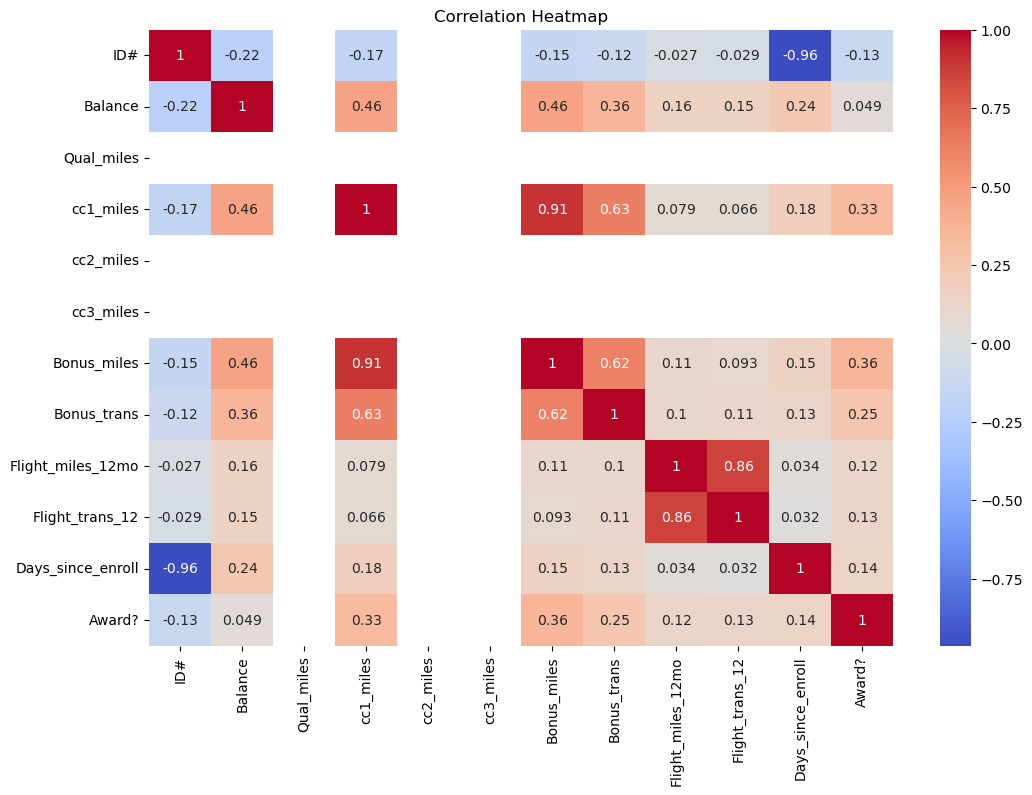

In [26]:
# Correlation Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df_clean.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


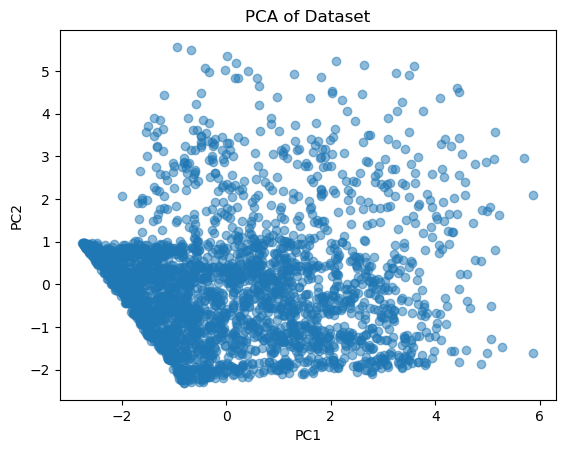

In [27]:
# PCA 2D Scatter
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
plt.scatter(df_pca[:,0], df_pca[:,1], alpha=0.5)
plt.title("PCA of Dataset")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


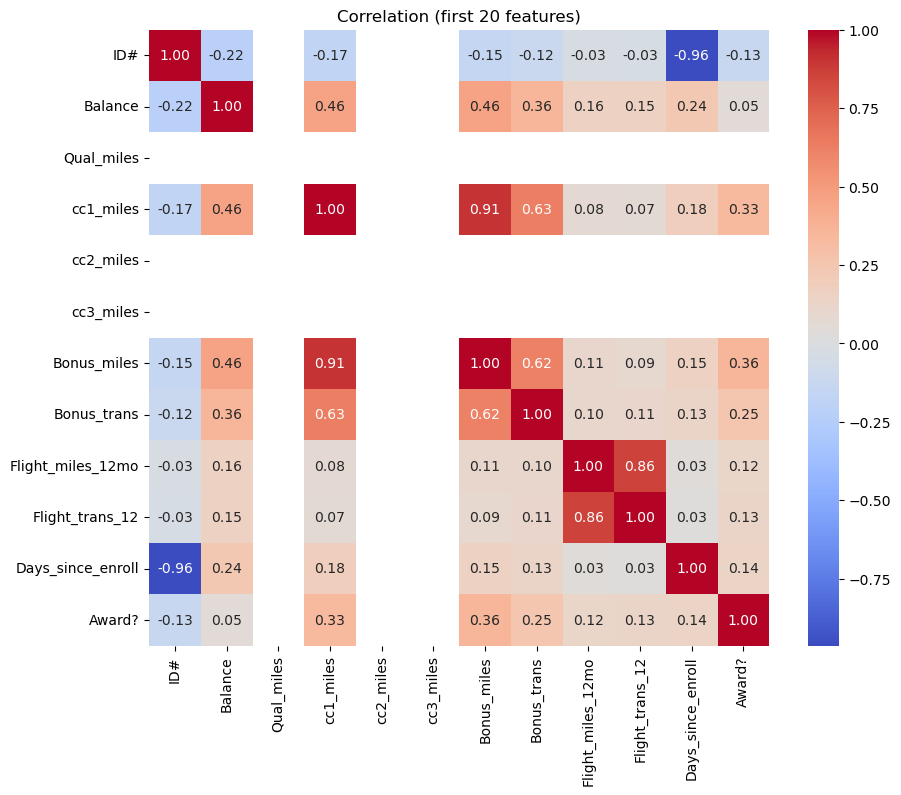

In [8]:
# correlation heatmap 
corr_cols = df_clean.columns[:20]
plt.figure(figsize=(10,8))
sns.heatmap(df_clean[corr_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation (first 20 features)")
plt.show()


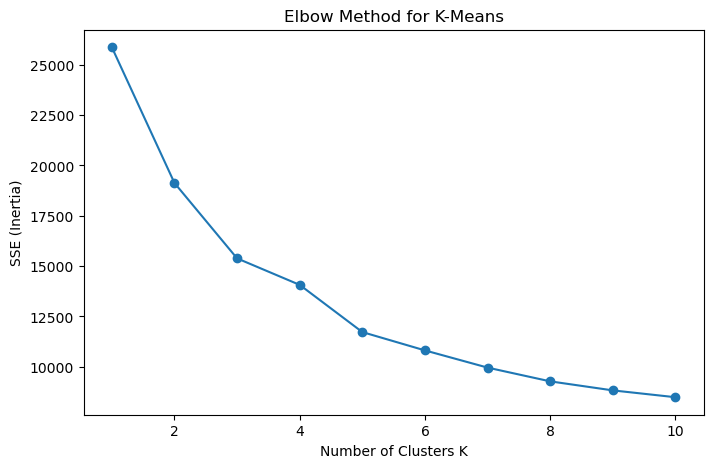

In [28]:
# Step 6: K-Means Clustering
# Elbow Method to determine optimal K
sse = []
K_range = range(1,11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, sse, marker='o')
plt.xlabel('Number of Clusters K')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method for K-Means')
plt.show()

K-Means Silhouette Score: 0.30830264215957265


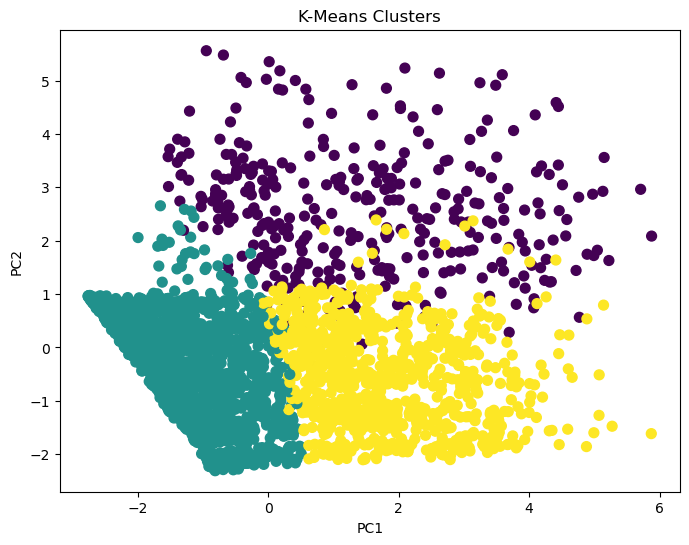

                        ID#       Balance  Qual_miles  cc1_miles  cc2_miles  \
KMeans_Cluster                                                                
0               2030.144044  65191.260388         0.0   2.047091        1.0   
1               2350.516423  28555.939781         0.0   1.086375        1.0   
2               1701.248276  73776.834483         0.0   3.144828        1.0   

                cc3_miles   Bonus_miles  Bonus_trans  Flight_miles_12mo  \
KMeans_Cluster                                                            
0                     1.0  14282.160665    11.725762         421.842105   
1                     1.0   2764.661800     5.359489           4.026156   
2                     1.0  24780.127586    16.022989           5.995402   

                Flight_trans_12  Days_since_enroll    Award?  
KMeans_Cluster                                                
0                      1.301939        4100.620499  0.443213  
1                      0.032847        

In [30]:
# Apply K-Means with chosen K (example K=3)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(df_scaled)
print(f"K-Means Silhouette Score: {silhouette_score(df_scaled, kmeans_labels)}")

# K-Means Cluster Visualization
plt.figure(figsize=(8,6))
plt.scatter(df_pca[:,0], df_pca[:,1], c=kmeans_labels, cmap='viridis', s=50)
plt.title("K-Means Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# K-Means Cluster Interpretation
df_clean['KMeans_Cluster'] = kmeans_labels
print(df_clean.groupby('KMeans_Cluster').mean())


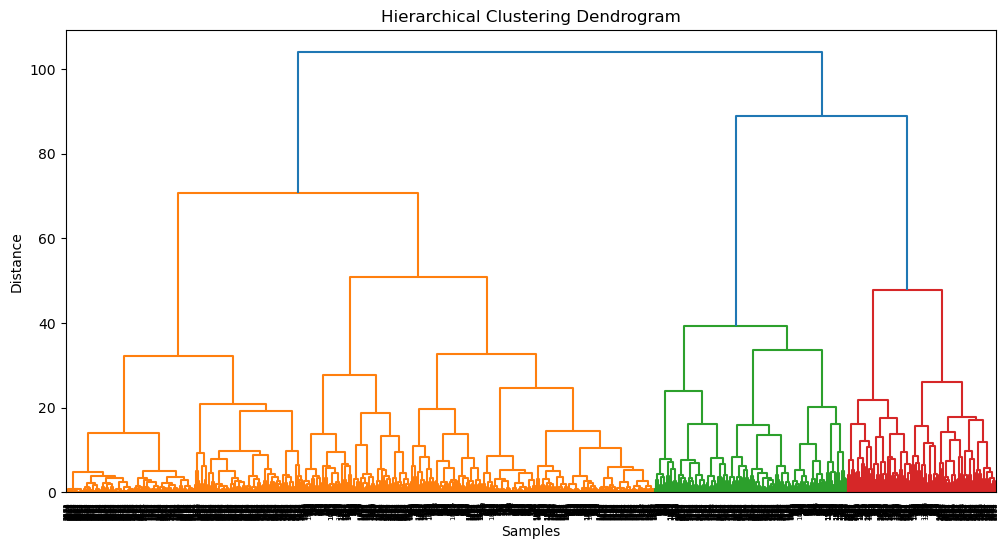

In [31]:
# Step 7: Hierarchical Clustering
# Dendrogram
plt.figure(figsize=(12,6))
linked = linkage(df_scaled, method='ward')
dendrogram(linked)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()


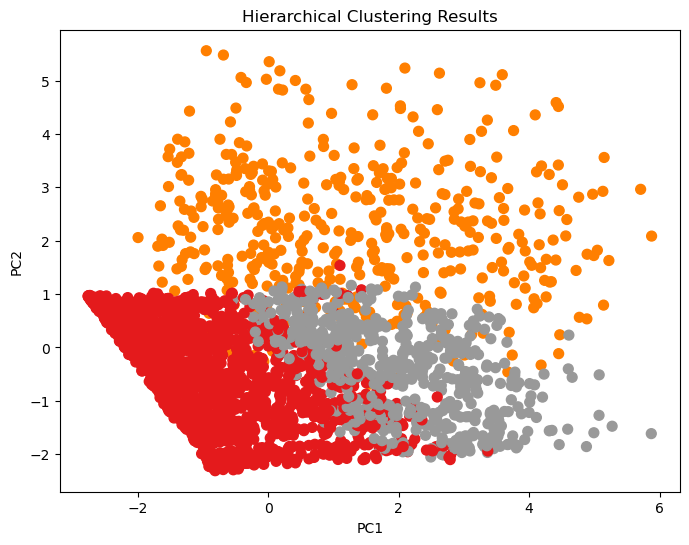

                       ID#       Balance  Qual_miles  cc1_miles  cc2_miles  \
Agglo_Cluster                                                                
0              2178.786498  32554.568057         0.0   1.240395        1.0   
1              2017.821351  61878.490196         0.0   2.052288        1.0   
2              1988.700337  79039.067340         0.0   3.466330        1.0   

               cc3_miles   Bonus_miles  Bonus_trans  Flight_miles_12mo  \
Agglo_Cluster                                                            
0                    1.0   4231.213502     6.747530           0.137212   
1                    1.0  14369.945534    11.294118         357.015251   
2                    1.0  28543.095960    16.003367           0.000000   

               Flight_trans_12  Days_since_enroll    Award?  KMeans_Cluster  
Agglo_Cluster                                                                
0                     0.001647        3796.383095  0.182217        1.134468  
1   

In [34]:
# Apply Agglomerative Clustering (example n_clusters=3)

agglo = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
agglo_labels = agglo.fit_predict(df_scaled)

# Visualization
plt.figure(figsize=(8,6))
plt.scatter(df_pca[:,0], df_pca[:,1], c=agglo_labels, cmap='Set1', s=50)
plt.title("Hierarchical Clustering Results")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Interpretation
df_clean['Agglo_Cluster'] = agglo_labels
print(df_clean.groupby('Agglo_Cluster').mean())

In [35]:
# Step 8: DBSCAN Clustering
# Experimentation with parameters
eps_values = [0.3, 0.5, 0.7]
min_samples_values = [3, 5, 7]

for eps in eps_values:
    for min_pts in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_pts)
        labels = dbscan.fit_predict(df_scaled)
        mask = labels != -1
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters > 1 and sum(mask) > 0:
            sil = silhouette_score(df_scaled[mask], labels[mask])
        else:
            sil = np.nan
        print(f"DBSCAN eps={eps}, min_samples={min_pts}, clusters={n_clusters}, silhouette={sil:.3f}")



DBSCAN eps=0.3, min_samples=3, clusters=46, silhouette=-0.279
DBSCAN eps=0.3, min_samples=5, clusters=9, silhouette=-0.113
DBSCAN eps=0.3, min_samples=7, clusters=9, silhouette=-0.191
DBSCAN eps=0.5, min_samples=3, clusters=74, silhouette=-0.137
DBSCAN eps=0.5, min_samples=5, clusters=25, silhouette=-0.163
DBSCAN eps=0.5, min_samples=7, clusters=16, silhouette=-0.080
DBSCAN eps=0.7, min_samples=3, clusters=58, silhouette=-0.016
DBSCAN eps=0.7, min_samples=5, clusters=18, silhouette=0.098
DBSCAN eps=0.7, min_samples=7, clusters=12, silhouette=0.116


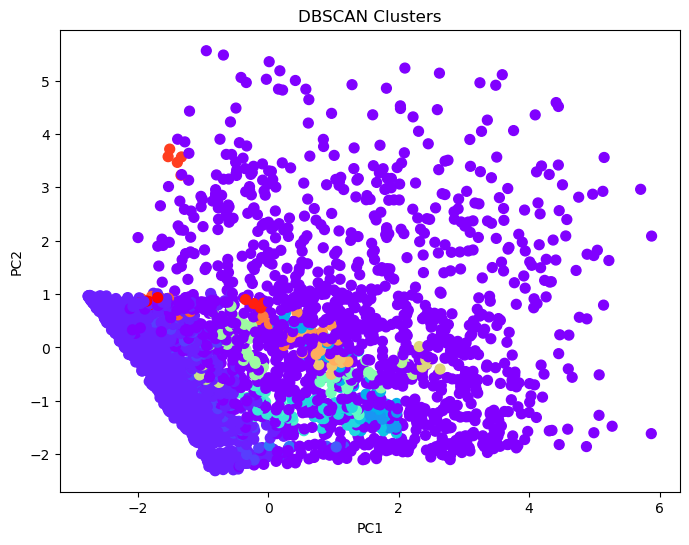

                        ID#        Balance  Qual_miles  cc1_miles  cc2_miles  \
DBSCAN_Cluster                                                                 
-1              1946.205674   69341.187943         0.0        2.4        1.0   
 0              2362.616831   20965.424351         0.0        1.0        1.0   
 1              1919.576923   21883.576923         0.0        1.0        1.0   
 2               281.800000    9765.200000         0.0        2.0        1.0   
 3               246.250000   52443.250000         0.0        1.0        1.0   
 4               875.666667   96366.777778         0.0        3.0        1.0   
 5              1824.689655   21741.086207         0.0        3.0        1.0   
 6               685.800000  111588.800000         0.0        3.0        1.0   
 7              1088.640000   49062.000000         0.0        3.0        1.0   
 8              1133.583333   31140.916667         0.0        2.0        1.0   
 9              1229.444444   13901.4444

In [36]:
# Apply final DBSCAN (example eps=0.5, min_samples=5)
dbscan_final = DBSCAN(eps=0.5, min_samples=5)
db_labels = dbscan_final.fit_predict(df_scaled)

plt.figure(figsize=(8,6))
plt.scatter(df_pca[:,0], df_pca[:,1], c=db_labels, cmap='rainbow', s=50)
plt.title("DBSCAN Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# DBSCAN Cluster Interpretation
df_clean['DBSCAN_Cluster'] = db_labels
print(df_clean.groupby('DBSCAN_Cluster').mean())
print(df_clean['DBSCAN_Cluster'].value_counts())